In [119]:
#!pip install girth
from girth import twopl_jml, ability_mle, ability_map
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
from uuid import  uuid4

seed(1)

In [41]:
def irf(diff: float, disc: float, ability: float):
    """Item Response (Characteristic) Function
    
    Compute the probability that a subject with given ability will answer an item 
    with difficulty `diff` and discrimination `disc` correctly
    
    """
    #return 1/(1 + exp_part(diff,disc,ability))
    return 1/(1+ np.exp(-disc*(ability-diff)))

In [7]:
def construct_lsat7_dataset(path_to_csv: str = "/home/daavid/lsat7.csv") -> pd.DataFrame:
    lsat7 = pd.read_csv(path_to_csv)
    lsat7 = lsat7.drop(columns="Unnamed: 0")
    lsat7 = lsat7.rename(columns={col:col.replace(".","_") for col in lsat7.columns})
    lsat7.index.repeat(lsat7.freq)
    expanded = pd.DataFrame(np.repeat(lsat7.values, lsat7.freq, axis=0),columns=lsat7.columns).drop(columns="freq")
    return expanded
    

In [10]:
lsat7= construct_lsat7_dataset()

In [17]:
params = twopl_jml(lsat7.transpose())

In [50]:
params_df =pd.DataFrame(params)
params_df

,Discrimination,Difficulty
0,0.80286,-1.202129
1,4.00000,0.368345
2,4.00000,0.058751
3,0.25000,1.380074
4,0.25000,-4.902024


In [36]:
#this approach has nans
#abilities = ability_mle(dataset=lsat7.transpose().to_numpy(), difficulty = params["Difficulty"], discrimination=params["Discrimination"])


In [34]:
len(abilities)

1000

In [37]:
abilities = ability_map(dataset=lsat7.transpose().to_numpy(), difficulty = params["Difficulty"], discrimination=params["Discrimination"])


(array([ 32.,   7.,  91.,   0.,   0.,  87., 223.,   0.,  66., 494.]),
 array([-0.85908197, -0.68427015, -0.50945833, -0.3346465 , -0.15983468,
         0.01497714,  0.18978896,  0.36460078,  0.53941261,  0.71422443,
         0.88903625]),
 <BarContainer object of 10 artists>)

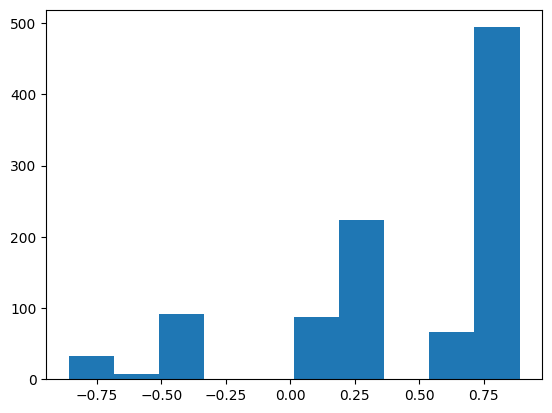

In [39]:

plt.hist(abilities)

In [65]:
predictions = list()
for ability in abilities:
    item_preds = list()
    for idx, (disc,diff) in params_df.iterrows():
        prob = irf(ability=ability, diff=diff, disc=disc)
        item_preds.append(round(prob))
    predictions.append(item_preds)
predictions

[[1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1,

In [70]:
len(predictions)

1000

In [69]:
len(lsat7.to_numpy())

1000

__Accuracy__

In [76]:
np.sum(predictions == lsat7.to_numpy())/5000

0.7738

__Goal here is to get a plot of sample size vs. accuracy__

In [95]:
def fit_model(dataset):
    item_params = twopl_jml(dataset.transpose())
    abilities = ability_map(dataset=dataset.transpose().to_numpy(), difficulty = item_params["Difficulty"], discrimination=item_params["Discrimination"])
    return item_params, abilities
    
def predict(abilities, item_params):
    predictions = list()
    item_params_df = pd.DataFrame(item_params)
    for ability in abilities:
        item_preds = list()
        for idx, (disc,diff) in item_params_df.iterrows():
            prob = irf(ability=ability, diff=diff, disc=disc)
            item_preds.append(round(prob))
        predictions.append(item_preds)
    return predictions
    
def get_acc(y_pred,y_true):
    y_true = y_true.to_numpy()
    return np.sum(y_pred == y_true)/y_true.size
    


In [80]:
it, ab = fit_model(lsat7)

In [84]:
preds = predict(abilities, params)

In [96]:
get_acc(y_pred = preds, y_true =lsat7)

0.7738

In [102]:
np.linspace(100,1000,10)

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.])

In [104]:
accs = list()
ns = np.linspace(100,1000,10).astype(int)
for n in ns:
    sample = lsat7.sample(n=n,random_state=1)
    item_params, abilities = fit_model(sample)
    preds = predict(abilities, item_params)
    acc = get_acc(y_pred = preds, y_true =sample)
    accs.append(acc)
    
    

In [105]:
accs

[0.756,
 0.767,
 0.7746666666666666,
 0.765,
 0.768,
 0.771,
 0.7525714285714286,
 0.7715,
 0.7726666666666666,
 0.7738]

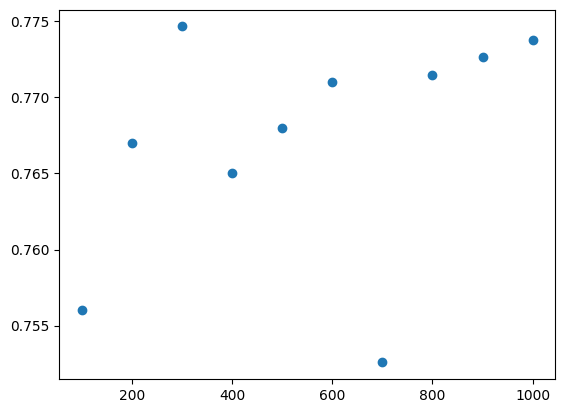

In [110]:
plt.scatter(np.linspace(100,1000,10).astype(int),accs)

n: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.44s/it]


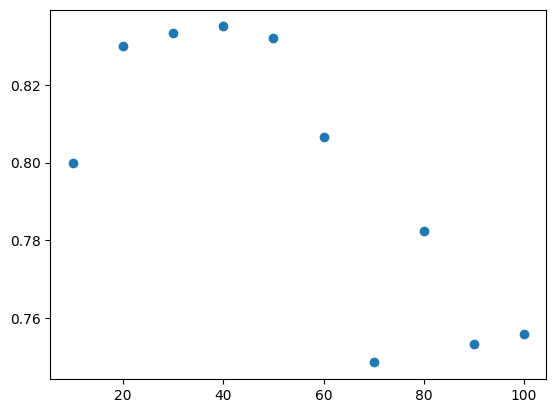

In [112]:
from tqdm import tqdm
accs = list()
ns = np.linspace(10,100,10).astype(int)
for n in tqdm(ns, "n"):
    n_acc = list()
    for i in tqdm(range(10)):
        sample = lsat7.sample(n=n,random_state=1)
        item_params, abilities = fit_model(sample)
        preds = predict(abilities, item_params)
        acc = get_acc(y_pred = preds, y_true =sample)
        n_acc.append(acc)
    acc = np.mean(n_acc)
    accs.append(acc)
    
plt.scatter(ns,accs)

This is training acuracy. I think this might have to do with the uneven response distribution. I wonder what it would look like with stratified sampling

In [120]:
#Let's try simulated data
N_ITEMS = 2000
N_SUBJECTS = 10_000
discriminations = np.random.gamma(size=N_ITEMS, shape=1, scale=2)
abilities = np.random.normal(size=N_SUBJECTS,loc=0,scale=1.01)
difficulties =   np.random.normal(size=N_ITEMS,loc=0,scale=1.01)
subjects = pd.DataFrame({"id": [str(uuid4()) for i in range(N_SUBJECTS) ], "ability": abilities})
items = pd.DataFrame({"id": [str(uuid4()) for i in range(N_ITEMS)], "difficulty": difficulties, "discrimination": discriminations })

<Axes: >

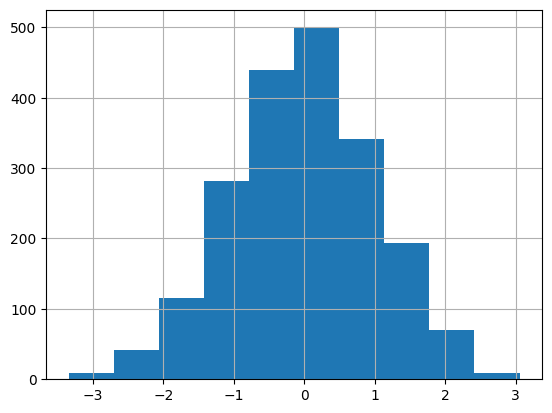

In [122]:
items.difficulty.hist()

<Axes: >

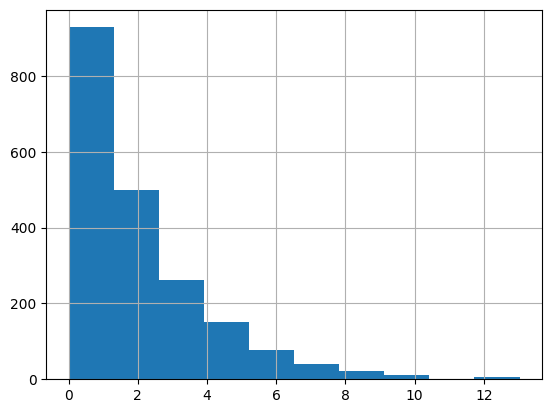

In [123]:
items.discrimination.hist()

In [124]:
items

,id,difficulty,discrimination
0,5f4a94a5-6204-4f02-9342-6b78d388914d,0.821853,1.079212
1,66a23c64-996f-4e8d-a44f-cc8f4d8040ae,0.865155,2.548251
2,50b1742d-9616-47bc-b1ba-2c82f74665d2,0.530961,0.000229
3,7ad1cd10-06ed-4170-aaa1-af1df00a9073,-0.127188,0.720026
4,6e19e0a6-e2f7-408c-b80d-1809c7cafbff,1.211208,0.317419
...,...,...,...
1995,b6ed32e9-767d-4804-b2a8-d3024724c2ee,0.661567,1.186633
1996,db73ed27-52a4-4ced-bf68-7cdb494df9a6,0.477096,0.406995
1997,8ad8cff5-1115-44b5-8ed4-3bddfc8c3b66,1.877074,3.529061
1998,58d4688a-8107-488d-b20e-9514c7c78a08,-1.374088,0.062977


In [126]:
def generate_subject_responses(subject):

    item_responses = items.apply(lambda item: {item["id"]: np.random.binomial(n=1,p=irf(diff=item["difficulty"],disc=item["discrimination"],ability=subject["ability"]))},axis=1).tolist()
    # item_responses = {"subject_id": subject["id"], 
    #                   "responses": {k:v for item in item_responses for k,v in item.items()}}
    return item_responses

In [128]:
subjects[:10].apply(generate_subject_responses,axis=1)

0    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
1    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
2    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
3    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
4    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
5    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
6    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
7    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
8    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
9    [{'5f4a94a5-6204-4f02-9342-6b78d388914d': 0}, ...
dtype: object